## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [23]:
df_FULL = df_transactions.groupby('customer_id').agg(
## create data set with RFM variables
frequency_FULL=('trans_date',pd.Series.nunique)
,monetary_value_FULL = ('tran_amount' ,sum)
## create data set with CLV variables
,ticket_size_FULL = ('tran_amount' ,np.mean)
,AOU_FULL = ('trans_date' ,lambda x: (x.max() - x.min()).days)
,spend_var_FULL = ('tran_amount' ,np.std)
,spend_per50_FULL = ('tran_amount' ,np.median)
)
df_FULL.fillna(0,inplace = True)
#df_FULL = df_FULL.reset_index()
df_FULL.head(20)

,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL
customer_id,,,,,,
CS1112,15,1012,67.466667,1309,19.766012,63.0
CS1113,19,1490,74.500000,1354,21.254102,79.5
CS1114,19,1432,75.368421,1309,21.341692,79.0
CS1115,22,1659,75.409091,1303,18.151896,72.5
CS1116,13,857,65.923077,1155,22.940000,60.0
CS1117,17,1185,69.705882,1139,19.444680,67.0
CS1118,15,1011,67.400000,1396,19.657060,63.0
CS1119,15,1158,77.200000,1101,22.763379,87.0
CS1120,24,1677,69.875000,1380,21.009961,67.0


In [8]:
df_3M = df_transactions[df_transactions['trans_date'] > '2014-12-17'].groupby('customer_id').agg(
## create data set with RFM variables
frequency_3M=('trans_date',pd.Series.nunique)
,monetary_value_3M = ('tran_amount' ,sum)
## create data set with CLV variables
,ticket_size_3M = ('tran_amount' ,np.mean)
,AOU_3M = ('trans_date' ,lambda x: (x.max() - x.min()).days)
,spend_var_3M = ('tran_amount' ,np.std)
,spend_per50_3M = ('tran_amount' ,np.median)
)

In [9]:
#df_3M = df_3M.reset_index()
df_3M.fillna(0,inplace = True)
df_3M.head(20)

,frequency_3M,monetary_value_3M,ticket_size_3M,AOU_3M,spend_var_3M,spend_per50_3M
customer_id,,,,,,
CS1112,1,39,39.000000,0,0.000000,39.0
CS1113,2,220,73.333333,26,27.300794,78.0
CS1114,2,174,87.000000,43,11.313708,87.0
CS1115,1,55,55.000000,0,0.000000,55.0
CS1118,1,60,60.000000,0,0.000000,60.0
CS1119,1,59,59.000000,0,0.000000,59.0
CS1120,6,332,55.333333,62,15.819819,49.5
CS1121,1,37,37.000000,0,0.000000,37.0
CS1122,1,81,81.000000,0,0.000000,81.0


In [10]:
df_6M = df_transactions[df_transactions['trans_date'] > '2014-9-17'].groupby('customer_id').agg(
## create data set with RFM variables
frequency_6M=('trans_date',pd.Series.nunique)
,monetary_value_6M = ('tran_amount' ,sum)
## create data set with CLV variables
,ticket_size_6M = ('tran_amount' ,np.mean)
,AOU_6M = ('trans_date' ,lambda x: (x.max() - x.min()).days)
,spend_var_6M = ('tran_amount' ,np.std)
,spend_per50_6M = ('tran_amount' ,np.median)
)
df_6M.fillna(0,inplace = True)
#df_6M = df_6M.reset_index()
df_6M.head(20)

,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M
customer_id,,,,,,
CS1112,2,98,49.000000,41,14.142136,49.0
CS1113,2,220,73.333333,26,27.300794,78.0
CS1114,3,211,70.333333,62,29.955523,79.0
CS1115,1,55,55.000000,0,0.000000,55.0
CS1118,4,308,77.000000,162,23.452079,76.5
CS1119,3,183,61.000000,164,26.057628,59.0
CS1120,7,407,58.142857,102,16.242214,53.0
CS1121,3,162,54.000000,124,18.083141,52.0
CS1122,1,81,81.000000,0,0.000000,81.0


In [11]:
df_12M = df_transactions[df_transactions['trans_date'] > '2014-5-17'].groupby('customer_id').agg(
## create data set with RFM variables
frequency_12M=('trans_date',pd.Series.nunique)
,monetary_value_12M = ('tran_amount' ,sum)
## create data set with CLV variables
,ticket_size_12M = ('tran_amount' ,np.mean)
,AOU_12M = ('trans_date' ,lambda x: (x.max() - x.min()).days)
,spend_var_12M = ('tran_amount' ,np.std)
,spend_per50_12M = ('tran_amount' ,np.median)
)
df_12M.fillna(0,inplace = True)
#df_12M = df_12M.reset_index()
df_12M.head(20)

,frequency_12M,monetary_value_12M,ticket_size_12M,AOU_12M,spend_var_12M,spend_per50_12M
customer_id,,,,,,
CS1112,3,188,62.666667,182,25.696952,59.0
CS1113,4,357,71.400000,258,28.032124,78.0
CS1114,5,315,63.000000,165,23.822258,58.0
CS1115,2,150,75.000000,260,28.284271,75.0
CS1116,3,190,63.333333,87,25.166115,60.0
CS1117,2,160,80.000000,10,19.798990,80.0
CS1118,5,385,77.000000,269,20.310096,77.0
CS1119,4,273,68.250000,174,25.747168,73.5
CS1120,7,407,58.142857,102,16.242214,53.0


In [12]:
df_24M = df_transactions[df_transactions['trans_date'] > '2013-5-17'].groupby('customer_id').agg(
## create data set with RFM variables
frequency_24M=('trans_date',pd.Series.nunique)
,monetary_value_24M = ('tran_amount' ,sum)
## create data set with CLV variables
,ticket_size_24M = ('tran_amount' ,np.mean)
,AOU_24M = ('trans_date' ,lambda x: (x.max() - x.min()).days)
,spend_var_24M = ('tran_amount' ,np.std)
,spend_per50_24M = ('tran_amount' ,np.median)
)
df_24M.fillna(0,inplace = True)
#df_24M = df_24M.reset_index()
df_24M.head(20)

,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M
customer_id,,,,,,
CS1112,6,358,59.666667,562,20.235283,61.0
CS1113,9,710,71.000000,601,25.108653,79.5
CS1114,11,804,73.090909,626,24.010225,79.0
CS1115,9,675,75.000000,616,16.294171,73.0
CS1116,5,333,66.600000,199,25.234896,60.0
CS1117,9,650,72.222222,409,16.991011,70.0
CS1118,11,757,68.818182,521,21.418768,60.0
CS1119,9,698,77.555556,604,20.464061,88.0
CS1120,12,762,63.500000,616,19.537842,57.5


In [62]:
#df_3M.drop(columns=['customer_id'],inplace=True)
#df_6M.drop(columns=['customer_id'],inplace=True)
#df_12M.drop(columns=['customer_id'],inplace=True)
#df_24M.drop(columns=['customer_id'],inplace=True)
#df_FULL.drop(columns=['customer_id'],inplace=True)


In [67]:
#df_combine = df_3M.join(df_6M).join(df_12M).join(df_24M).join(df_response)
df_combine = df_6M.join(df_24M).join(df_FULL)
df_combine.head(50)

,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL
customer_id,,,,,,,,,,,,,,,,,,
CS1112,2,98,49.000000,41,14.142136,49.0,6,358,59.666667,562,20.235283,61.0,15,1012,67.466667,1309,19.766012,63.0
CS1113,2,220,73.333333,26,27.300794,78.0,9,710,71.000000,601,25.108653,79.5,19,1490,74.500000,1354,21.254102,79.5
CS1114,3,211,70.333333,62,29.955523,79.0,11,804,73.090909,626,24.010225,79.0,19,1432,75.368421,1309,21.341692,79.0
CS1115,1,55,55.000000,0,0.000000,55.0,9,675,75.000000,616,16.294171,73.0,22,1659,75.409091,1303,18.151896,72.5
CS1118,4,308,77.000000,162,23.452079,76.5,11,757,68.818182,521,21.418768,60.0,15,1011,67.400000,1396,19.657060,63.0
CS1119,3,183,61.000000,164,26.057628,59.0,9,698,77.555556,604,20.464061,88.0,15,1158,77.200000,1101,22.763379,87.0
CS1120,7,407,58.142857,102,16.242214,53.0,12,762,63.500000,616,19.537842,57.5,24,1677,69.875000,1380,21.009961,67.0
CS1121,3,162,54.000000,124,18.083141,52.0,7,340,48.571429,394,12.895182,43.0,25,1524,58.615385,1345,21.879812,50.0
CS1122,1,81,81.000000,0,0.000000,81.0,5,407,81.400000,579,18.822858,90.0,16,1156,72.250000,1294,21.324477,78.0


In [68]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


In [69]:
## create data set with RFM variables

df_rfm = df_combine   
df_rfm.head(10) 


,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL
customer_id,,,,,,,,,,,,,,,,,,
CS1112,2,98,49.000000,41,14.142136,49.0,6,358,59.666667,562,20.235283,61.0,15,1012,67.466667,1309,19.766012,63.0
CS1113,2,220,73.333333,26,27.300794,78.0,9,710,71.000000,601,25.108653,79.5,19,1490,74.500000,1354,21.254102,79.5
CS1114,3,211,70.333333,62,29.955523,79.0,11,804,73.090909,626,24.010225,79.0,19,1432,75.368421,1309,21.341692,79.0
CS1115,1,55,55.000000,0,0.000000,55.0,9,675,75.000000,616,16.294171,73.0,22,1659,75.409091,1303,18.151896,72.5
CS1118,4,308,77.000000,162,23.452079,76.5,11,757,68.818182,521,21.418768,60.0,15,1011,67.400000,1396,19.657060,63.0
CS1119,3,183,61.000000,164,26.057628,59.0,9,698,77.555556,604,20.464061,88.0,15,1158,77.200000,1101,22.763379,87.0
CS1120,7,407,58.142857,102,16.242214,53.0,12,762,63.500000,616,19.537842,57.5,24,1677,69.875000,1380,21.009961,67.0
CS1121,3,162,54.000000,124,18.083141,52.0,7,340,48.571429,394,12.895182,43.0,25,1524,58.615385,1345,21.879812,50.0
CS1122,1,81,81.000000,0,0.000000,81.0,5,407,81.400000,579,18.822858,90.0,16,1156,72.250000,1294,21.324477,78.0


In [70]:
## create data set with CLV variables

df_clv = df_combine
df_clv.head(10) 

,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL
customer_id,,,,,,,,,,,,,,,,,,
CS1112,2,98,49.000000,41,14.142136,49.0,6,358,59.666667,562,20.235283,61.0,15,1012,67.466667,1309,19.766012,63.0
CS1113,2,220,73.333333,26,27.300794,78.0,9,710,71.000000,601,25.108653,79.5,19,1490,74.500000,1354,21.254102,79.5
CS1114,3,211,70.333333,62,29.955523,79.0,11,804,73.090909,626,24.010225,79.0,19,1432,75.368421,1309,21.341692,79.0
CS1115,1,55,55.000000,0,0.000000,55.0,9,675,75.000000,616,16.294171,73.0,22,1659,75.409091,1303,18.151896,72.5
CS1118,4,308,77.000000,162,23.452079,76.5,11,757,68.818182,521,21.418768,60.0,15,1011,67.400000,1396,19.657060,63.0
CS1119,3,183,61.000000,164,26.057628,59.0,9,698,77.555556,604,20.464061,88.0,15,1158,77.200000,1101,22.763379,87.0
CS1120,7,407,58.142857,102,16.242214,53.0,12,762,63.500000,616,19.537842,57.5,24,1677,69.875000,1380,21.009961,67.0
CS1121,3,162,54.000000,124,18.083141,52.0,7,340,48.571429,394,12.895182,43.0,25,1524,58.615385,1345,21.879812,50.0
CS1122,1,81,81.000000,0,0.000000,81.0,5,407,81.400000,579,18.822858,90.0,16,1156,72.250000,1294,21.324477,78.0


## **Calculating response rate**

In [57]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


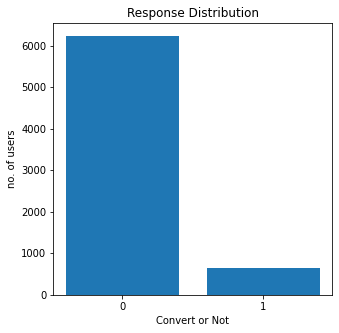

In [58]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [59]:
df_combine.tail(10)

,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL
customer_id,,,,,,,,,,,,,,,,,,
CS8989,2,109,54.5,105,0.707107,54.5,6,375,62.500000,450,10.212737,60.0,15,815,54.333333,1174,18.164591,54.0
CS8990,5,229,45.8,71,24.993999,44.0,8,360,45.000000,434,20.996598,43.5,13,613,47.153846,1240,20.136394,49.0
CS8991,4,180,45.0,99,20.575066,43.5,7,350,50.000000,232,23.986107,58.0,14,602,43.000000,1306,21.982511,47.0
CS8992,1,40,40.0,0,0.000000,40.0,4,166,41.500000,386,5.802298,39.5,9,277,30.777778,1054,13.700162,37.0
CS8993,1,18,18.0,0,0.000000,18.0,4,69,17.250000,520,7.804913,15.0,10,409,40.900000,1263,26.434195,38.0
CS8994,1,27,27.0,0,0.000000,27.0,8,312,39.000000,571,17.146428,39.0,16,749,46.812500,1222,18.594690,45.0
CS8995,1,38,38.0,0,0.000000,38.0,2,108,54.000000,346,22.627417,54.0,7,347,49.571429,1318,25.422150,42.0
CS8996,5,293,58.6,26,23.479779,68.0,7,369,52.714286,377,21.838149,43.0,13,582,44.769231,1120,18.749017,38.0
CS8998,2,82,41.0,61,11.313708,41.0,4,130,32.500000,153,14.821156,34.0,13,624,48.000000,1293,22.319648,49.0


In [71]:
print(df_response.size)
print(df_rfm.size)

13768
110610


In [72]:
df_response.set_index("customer_id")

,response
customer_id,
CS1112,0
CS1113,0
CS1114,1
CS1115,1
CS1116,1
...,...
CS8996,0
CS8997,0
CS8998,0


In [73]:
df_combine = df_combine.join(df_response.set_index('customer_id'))
## create data set with RFM variables

df_rfm = df_combine   
df_rfm.head(10) 


## create data set with CLV variables

df_clv = df_combine
df_clv.head(10) 

,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL,response
customer_id,,,,,,,,,,,,,,,,,,,
CS1112,2,98,49.000000,41,14.142136,49.0,6,358,59.666667,562,20.235283,61.0,15,1012,67.466667,1309,19.766012,63.0,0
CS1113,2,220,73.333333,26,27.300794,78.0,9,710,71.000000,601,25.108653,79.5,19,1490,74.500000,1354,21.254102,79.5,0
CS1114,3,211,70.333333,62,29.955523,79.0,11,804,73.090909,626,24.010225,79.0,19,1432,75.368421,1309,21.341692,79.0,1
CS1115,1,55,55.000000,0,0.000000,55.0,9,675,75.000000,616,16.294171,73.0,22,1659,75.409091,1303,18.151896,72.5,1
CS1118,4,308,77.000000,162,23.452079,76.5,11,757,68.818182,521,21.418768,60.0,15,1011,67.400000,1396,19.657060,63.0,1
CS1119,3,183,61.000000,164,26.057628,59.0,9,698,77.555556,604,20.464061,88.0,15,1158,77.200000,1101,22.763379,87.0,0
CS1120,7,407,58.142857,102,16.242214,53.0,12,762,63.500000,616,19.537842,57.5,24,1677,69.875000,1380,21.009961,67.0,0
CS1121,3,162,54.000000,124,18.083141,52.0,7,340,48.571429,394,12.895182,43.0,25,1524,58.615385,1345,21.879812,50.0,0
CS1122,1,81,81.000000,0,0.000000,81.0,5,407,81.400000,579,18.822858,90.0,16,1156,72.250000,1294,21.324477,78.0,0


In [74]:
list(df_response)
list(df_combine)

['frequency_6M',
 'monetary_value_6M',
 'ticket_size_6M',
 'AOU_6M',
 'spend_var_6M',
 'spend_per50_6M',
 'frequency_24M',
 'monetary_value_24M',
 'ticket_size_24M',
 'AOU_24M',
 'spend_var_24M',
 'spend_per50_24M',
 'frequency_FULL',
 'monetary_value_FULL',
 'ticket_size_FULL',
 'AOU_FULL',
 'spend_var_FULL',
 'spend_per50_FULL',
 'response']

In [75]:
## merging two data sets - RFM

df_modeling_rfm = df_rfm
df_modeling_rfm.head()

,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL,response
customer_id,,,,,,,,,,,,,,,,,,,
CS1112,2,98,49.000000,41,14.142136,49.0,6,358,59.666667,562,20.235283,61.0,15,1012,67.466667,1309,19.766012,63.0,0
CS1113,2,220,73.333333,26,27.300794,78.0,9,710,71.000000,601,25.108653,79.5,19,1490,74.500000,1354,21.254102,79.5,0
CS1114,3,211,70.333333,62,29.955523,79.0,11,804,73.090909,626,24.010225,79.0,19,1432,75.368421,1309,21.341692,79.0,1
CS1115,1,55,55.000000,0,0.000000,55.0,9,675,75.000000,616,16.294171,73.0,22,1659,75.409091,1303,18.151896,72.5,1
CS1118,4,308,77.000000,162,23.452079,76.5,11,757,68.818182,521,21.418768,60.0,15,1011,67.400000,1396,19.657060,63.0,1


In [76]:
## merging two data sets - CLV

df_modeling_clv = df_clv
df_modeling_clv.head()

,frequency_6M,monetary_value_6M,ticket_size_6M,AOU_6M,spend_var_6M,spend_per50_6M,frequency_24M,monetary_value_24M,ticket_size_24M,AOU_24M,spend_var_24M,spend_per50_24M,frequency_FULL,monetary_value_FULL,ticket_size_FULL,AOU_FULL,spend_var_FULL,spend_per50_FULL,response
customer_id,,,,,,,,,,,,,,,,,,,
CS1112,2,98,49.000000,41,14.142136,49.0,6,358,59.666667,562,20.235283,61.0,15,1012,67.466667,1309,19.766012,63.0,0
CS1113,2,220,73.333333,26,27.300794,78.0,9,710,71.000000,601,25.108653,79.5,19,1490,74.500000,1354,21.254102,79.5,0
CS1114,3,211,70.333333,62,29.955523,79.0,11,804,73.090909,626,24.010225,79.0,19,1432,75.368421,1309,21.341692,79.0,1
CS1115,1,55,55.000000,0,0.000000,55.0,9,675,75.000000,616,16.294171,73.0,22,1659,75.409091,1303,18.151896,72.5,1
CS1118,4,308,77.000000,162,23.452079,76.5,11,757,68.818182,521,21.418768,60.0,15,1011,67.400000,1396,19.657060,63.0,1


## **Creating train and test dataset**

In [78]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response'])
y_clv = df_modeling_clv['response']

In [79]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

## **Fixing imbalanced with SMOTE**

In [80]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [81]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      3904
           1       0.72      0.77      0.74      3904

    accuracy                           0.73      7808
   macro avg       0.73      0.73      0.73      7808
weighted avg       0.73      0.73      0.73      7808

test set
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1662
           1       0.20      0.69      0.31       182

    accuracy                           0.70      1844
   macro avg       0.58      0.69      0.56      1844
weighted avg       0.88      0.70      0.76      1844



In [82]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      3904
           1       0.72      0.77      0.74      3904

    accuracy                           0.73      7808
   macro avg       0.73      0.73      0.73      7808
weighted avg       0.73      0.73      0.73      7808

test set
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1662
           1       0.20      0.69      0.31       182

    accuracy                           0.70      1844
   macro avg       0.58      0.69      0.56      1844
weighted avg       0.88      0.70      0.76      1844



## **XGBoost**

In [83]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.73772
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.752651
[2]	validation_0-auc:0.750899
[3]	validation_0-auc:0.750519
[4]	validation_0-auc:0.750896
[5]	validation_0-auc:0.750853
[6]	validation_0-auc:0.751263
Stopping. Best iteration:
[1]	validation_0-auc:0.752651

training set
              precision    recall  f1-score   support

           0       0.83      0.56      0.67      3904
           1       0.67      0.89      0.76      3904

    accuracy                           0.72      7808
   macro avg       0.75      0.72      0.72      7808
weighted avg       0.75      0.72      0.72      7808

test set
              precision    recall  f1-score   support

           0       0.96      0.56      0.71      1662
           1       0.17      0.81      0.28       182

    accuracy                           0.59      1844
   macro avg       0.57      0.68      0.49      1844
weighted avg       0.89 

In [84]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.73772
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.752651
[2]	validation_0-auc:0.750899
[3]	validation_0-auc:0.750519
[4]	validation_0-auc:0.750896
[5]	validation_0-auc:0.750853
[6]	validation_0-auc:0.751263
Stopping. Best iteration:
[1]	validation_0-auc:0.752651

training set
              precision    recall  f1-score   support

           0       0.83      0.56      0.67      3904
           1       0.67      0.89      0.76      3904

    accuracy                           0.72      7808
   macro avg       0.75      0.72      0.72      7808
weighted avg       0.75      0.72      0.72      7808

test set
              precision    recall  f1-score   support

           0       0.96      0.56      0.71      1662
           1       0.17      0.81      0.28       182

    accuracy                           0.59      1844
   macro avg       0.57      0.68      0.49      1844
weighted avg       0.89 

In [85]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [86]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.7min finished


In [87]:
predicted_y = []
expected_y = []

predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7509547278211229
[[1007  655]
 [  41  141]]
test set
              precision    recall  f1-score   support

           0       0.96      0.61      0.74      1662
           1       0.18      0.77      0.29       182

    accuracy                           0.62      1844
   macro avg       0.57      0.69      0.52      1844
weighted avg       0.88      0.62      0.70      1844



In [88]:
from sklearn.metrics import roc_auc_score
auc_train = roc_auc_score(y_train_clv, xgb_model_clv_GS.predict_proba(X_train_clv)[:, 1])
auc_test = roc_auc_score(y_test_clv, xgb_model_clv_GS.predict_proba(X_test_clv)[:, 1])
print(f"AUC Train : {auc_train:.4f}")
print(f"AUC Test : {auc_test:.4f}")

AUC Train : 0.7720
AUC Test : 0.7446


In [44]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.1, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f873a0a30e0>}
